In [1]:
###################### For files uploading #####################################
# import os
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

Saving international-airline-passengers.csv to international-airline-passengers.csv
User uploaded file "international-airline-passengers.csv" with length 2334 bytes


In [3]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [0]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [0]:
# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [7]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [0]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)


In [0]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [0]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)
print(testX.shape)

#### Creating and training model

In [16]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
 - 1s - loss: 0.0314
Epoch 2/50
 - 1s - loss: 0.0140
Epoch 3/50
 - 1s - loss: 0.0107
Epoch 4/50
 - 1s - loss: 0.0098
Epoch 5/50
 - 1s - loss: 0.0090
Epoch 6/50
 - 1s - loss: 0.0082
Epoch 7/50
 - 1s - loss: 0.0073
Epoch 8/50
 - 1s - loss: 0.0064
Epoch 9/50
 - 1s - loss: 0.0057
Epoch 10/50
 - 1s - loss: 0.0050
Epoch 11/50
 - 1s - loss: 0.0043
Epoch 12/50
 - 1s - loss: 0.0039
Epoch 13/50
 - 1s - loss: 0.0033
Epoch 14/50
 - 1s - loss: 0.0029
Epoch 15/50
 - 1s - loss: 0.0027
Epoch 16/50
 - 1s - loss: 0.0025
Epoch 17/50
 - 1s - loss: 0.0024
Epoch 18/50
 - 1s - loss: 0.0022
Epoch 19/50
 - 1s - loss: 0.0021
Epoch 20/50
 - 1s - loss: 0.0021
Epoch 21/50
 - 1s - loss: 0.0021
Epoch 22/50
 - 1s - loss: 0.0021
Epoch 23/50
 - 1s - loss: 0.0021
Epoch 24/50
 - 1s - loss: 0.0021
Epoch 25/50
 - 1s - loss: 0.0021
Epoch 26/50
 - 1s - loss: 0.0021
Epoch 27/50
 - 1s - loss: 0.0021
Epoch 28/50
 - 1s - loss: 0.0020
Epoch 29/50
 - 1s - loss: 0.0020
Epoch 30/50
 - 1s - loss: 0.0020
Epoch 31/50
 - 1s -

#### Predicting

In [17]:
# Note that we invert the predictions before calculating error scores to ensure that
# performance is reported in the same units as the original data (thousands of passengers per month).

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.72 RMSE
Test Score: 50.38 RMSE


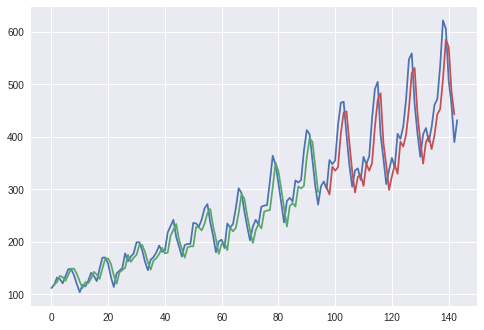

In [18]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()